# Compare Various Cloud-Related Fields from UPP

shawn.s.murdzek@noaa.gov

In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import yaml
import metpy.calc as mc
from metpy.units import units
import metpy.constants as const
import datetime as dt

import pyDA_utils.plot_model_data as pmd
import pyDA_utils.bufr as bufr
import pyDA_utils.ensemble_utils as eu

In [69]:
"""
Input Parameters
"""

date = dt.datetime(2022, 2, 1, 18)

# RRFS UPP output file
fname = date.strftime('/mnt/lfs4/BMC/wrfruc/murdzek/RRFS_Ens_Cloud_DA/Feb2022_retro/Ens_GDAS_SDLVDL_noGF_cloud1/v0.6.2/prod/rrfs_conus_3km_ensda.%Y%m%d/%H/mem0001/rrfs.t%Hz.prslev.f001.conus_3km.grib2')
#fname = date.strftime('/lfs1/BMC/wrfruc/chunhua/Aug2023_retro/beta_testing/v0.8.1/prod/rrfs.%Y%m%d/%H/rrfs.t%Hz.prslev.f001.conus_3km.grib2')

# Ceiling field to examine
ceil_fields = ['HGT_P0_L215_GLC0', 'CEIL_P0_L215_GLC0', 'CEIL_P0_L2_GLC0', 'HGT_P0_L2_GLC0']
ceil_names = ['ceiling', 'ceil_exp1', 'ceil_exp2', 'cld_base']
ceil_miss = [np.nan, np.nan, 20000, -5000]

In [70]:
"""
Read UPP output
"""

upp_ds = xr.open_dataset(fname, engine='pynio')

In [71]:
"""
Print all UPP Fields
"""

for k in list(upp_ds.keys()):
    print('{var}: {name}'.format(var=k, name=upp_ds[k].attrs['long_name']))

TMP_P0_L1_GLC0: Temperature
TMP_P0_L3_GLC0: Temperature
TMP_P0_L7_GLC0: Temperature
TMP_P0_L100_GLC0: Temperature
TMP_P0_L102_GLC0: Temperature
TMP_P0_L103_GLC0: Temperature
TMP_P0_L104_GLC0: Temperature
TMP_P0_L105_GLC0: Temperature
TMP_P0_2L108_GLC0: Temperature
POT_P0_L1_GLC0: Potential temperature
POT_P0_L7_GLC0: Potential temperature
POT_P0_L103_GLC0: Potential temperature
POT_P0_L105_GLC0: Potential temperature
POT_P0_2L108_GLC0: Potential temperature
DPT_P0_L100_GLC0: Dew point temperature
DPT_P0_L103_GLC0: Dew point temperature
DPT_P0_L105_GLC0: Dew point temperature
DPT_P0_2L108_GLC0: Dew point temperature
LHTFL_P0_L1_GLC0: Latent heat net flux
SHTFL_P0_L1_GLC0: Sensible heat net flux
VAR_0_0_205_P0_L247_GLC0: unknown variable name
SPFH_P0_L1_GLC0: Specific humidity
SPFH_P0_L100_GLC0: Specific humidity
SPFH_P0_L102_GLC0: Specific humidity
SPFH_P0_L103_GLC0: Specific humidity
SPFH_P0_L105_GLC0: Specific humidity
SPFH_P0_2L108_GLC0: Specific humidity
RH_P0_L4_GLC0: Relative humi

In [72]:
"""
Examine Basic Cloud Ceiling Information
"""

for f, name in zip(ceil_fields, ceil_names):
    print()
    print(f'field = {f} ({name})')
    print('Units = {u}'.format(u=upp_ds[f].attrs['units']))
    print('Long name = {l}'.format(l=upp_ds[f].attrs['long_name']))
    print('Level type = {l}'.format(l=upp_ds[f].attrs['level_type']))
    print('Number of NaNs = {n}'.format(n=np.sum(np.isnan(upp_ds[f].values))))
    print('Number of 20000 = {n}'.format(n=np.sum(np.isclose(upp_ds[f].values, 20000))))
    print('Number of -2500 = {n}'.format(n=np.sum(np.isclose(upp_ds[f].values, -2500))))
    print('Number of -5000 = {n}'.format(n=np.sum(np.isclose(upp_ds[f].values, -5000))))
    print('Max = {n}'.format(n=np.nanmax(upp_ds[f])))
    print('Min = {n}'.format(n=np.nanmin(upp_ds[f])))


field = HGT_P0_L215_GLC0 (ceiling)
Units = gpm
Long name = Geopotential height
Level type = Cloud ceiling
Number of NaNs = 1278376
Number of 20000 = 0
Number of -2500 = 0
Number of -5000 = 0
Max = 11944.4462890625
Min = 27.32147216796875

field = CEIL_P0_L215_GLC0 (ceil_exp1)
Units = m
Long name = Ceiling
Level type = Cloud ceiling
Number of NaNs = 1220240
Number of 20000 = 0
Number of -2500 = 0
Number of -5000 = 0
Max = 11585.8251953125
Min = 27.324996948242188

field = CEIL_P0_L2_GLC0 (ceil_exp2)
Units = m
Long name = Ceiling
Level type = Cloud base level
Number of NaNs = 0
Number of 20000 = 1220276
Number of -2500 = 0
Number of -5000 = 0
Max = 19999.94921875
Min = 27.324996948242188

field = HGT_P0_L2_GLC0 (cld_base)
Units = gpm
Long name = Geopotential height
Level type = Cloud base level
Number of NaNs = 0
Number of 20000 = 0
Number of -2500 = 0
Number of -5000 = 1549529
Max = 11342.0
Min = -5000.0


In [73]:
"""
Create 1D Fields for Plotting
"""

# Create 1D fields first and arbitrarily set NaNs to -2500
fields1D = {}
maxval = 0
minval = 0
for f in ceil_fields:
    fields1D[f] = upp_ds[f].values.ravel()
    fields1D[f][np.isnan(fields1D[f])] = -2500
    minval = min(minval, np.nanmin(fields1D[f]))
    maxval = max(maxval, np.nanmax(fields1D[f]))
    
minval = minval - 500
maxval = maxval + 500

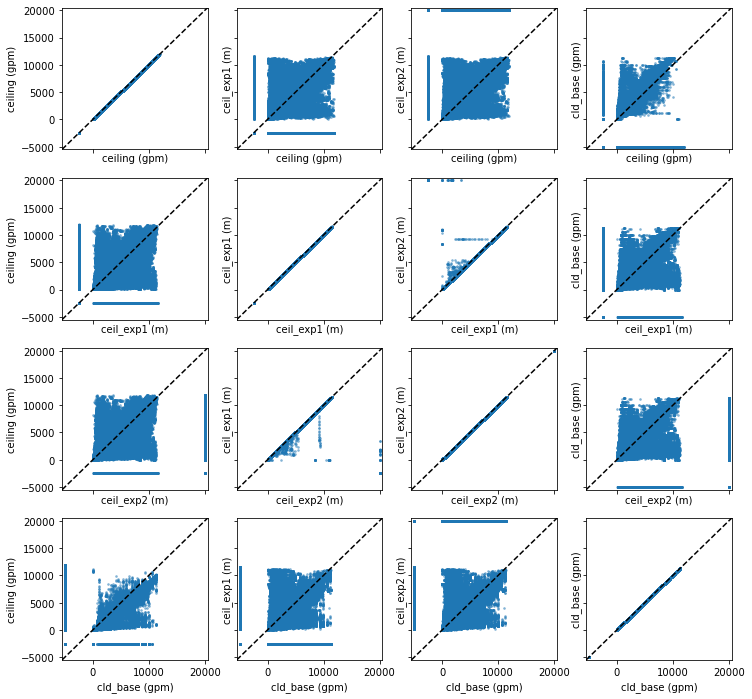

In [74]:
"""
Create Scatterplot of Ceilings
"""

# Make plot
nfields = len(ceil_fields)
fig, axes = plt.subplots(nrows=nfields, ncols=nfields, figsize=(12, 12), sharex=True, sharey=True)
for i, (f1, name1) in enumerate(zip(ceil_fields, ceil_names)):
    for j, (f2, name2) in enumerate(zip(ceil_fields, ceil_names)):
        ax = axes[i, j]
        ax.scatter(fields1D[f1], fields1D[f2], s=3, alpha=0.4)
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel('{n} ({units})'.format(n=name1, units=upp_ds[f1].attrs['units']))
        ax.set_ylabel('{n} ({units})'.format(n=name2, units=upp_ds[f2].attrs['units']))
        ax.set_xlim([minval, maxval])
        ax.set_ylim([minval, maxval])
plt.savefig(date.strftime('ceil_scatter_%Y%m%d_%H.png'))

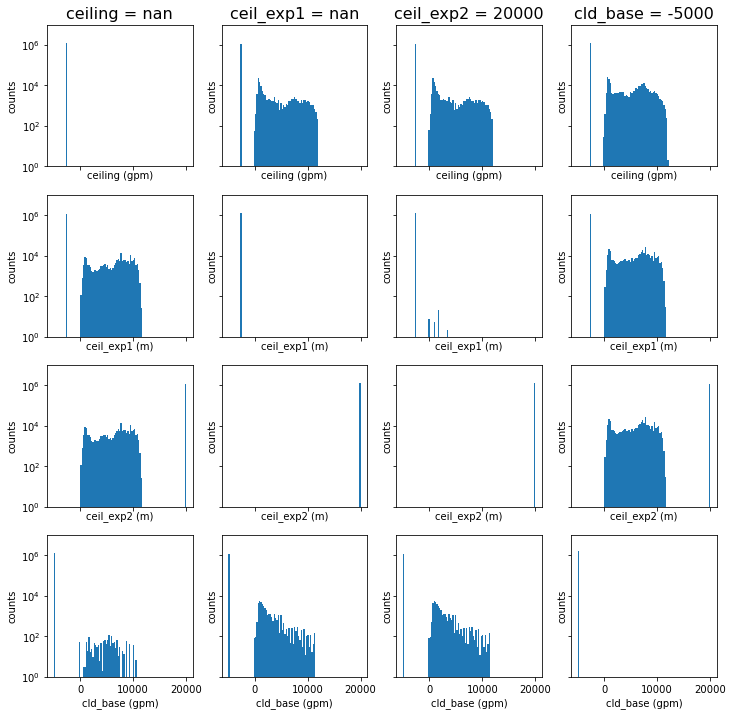

In [75]:
"""
Plot Histograms of Values for Each Ceiling When One of the Ceiling Diagnostics is Missing
"""

# Make plot
nfields = len(ceil_fields)
bins = np.linspace(-5000, 20000, 100)
fig, axes = plt.subplots(nrows=nfields, ncols=nfields, figsize=(12, 12), sharex=True, sharey=True)
for i, (f1, name1, miss) in enumerate(zip(ceil_fields, ceil_names, ceil_miss)):
    axes[0, i].set_title(f'{name1} = {miss}', size=16)
    if np.isnan(miss):
        cond = np.logical_or(np.isnan(fields1D[f1]), np.isclose(fields1D[f1], -2500))
    else:
        cond = np.isclose(fields1D[f1], miss)
    for j, (f2, name2) in enumerate(zip(ceil_fields, ceil_names)):
        ax = axes[j, i]
        ax.hist(fields1D[f2][cond], bins=bins)
        ax.set_xlabel('{n} ({units})'.format(n=name2, units=upp_ds[f2].attrs['units']))
        ax.set_ylabel('counts')
        ax.set_yscale('log')
        ax.set_ylim([1, 1e7])
plt.savefig(date.strftime('ceil_miss_hist_%Y%m%d_%H.png'))

Text(0.5, 1.0, 'Diagnosed Ceiling (Exp #2) But No Cloud Base')

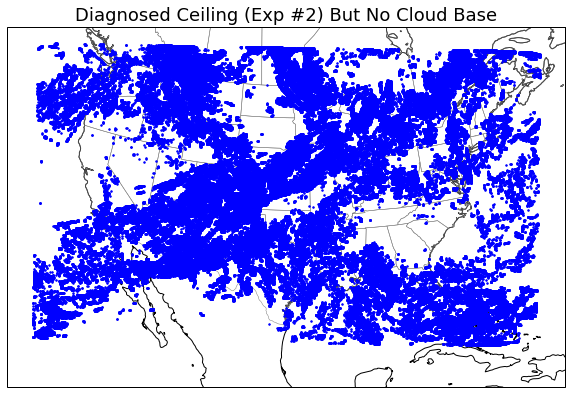

In [89]:
"""
Plot Locations Where Ceiling Exp #2 Has a Ceiling but Cloud Base is Missing
"""

cond = np.logical_and(upp_ds['CEIL_P0_L2_GLC0'] < 19999, np.isclose(upp_ds['HGT_P0_L2_GLC0'], -5000))
lats = upp_ds['gridlat_0'].values[cond].ravel()
lons = upp_ds['gridlon_0'].values[cond].ravel()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
ax.plot(lons, lats, 'b.', ms=3, transform=ccrs.PlateCarree())

scale = '50m'
ax.coastlines(scale)
borders = cfeature.NaturalEarthFeature(category='cultural',
                                       scale=scale,
                                       facecolor='none',
                                       name='admin_1_states_provinces')
ax.add_feature(borders, linewidth=0.5, edgecolor='gray')
ax.set_title('Diagnosed Ceiling (Exp #2) But No Cloud Base', size=18)